In [4]:
import random
import numpy as np
from skimage import io, util
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
import os
import pickle
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Function to convert mask to y
def mask_to_y(mask):
    return mask.flatten()

# Function to extract patches from the green channel of an image
def image_to_X(image, patch_size=5):
    pad_size = patch_size // 2
    padded = np.pad(image[:, :, 1], (pad_size, pad_size), mode='constant', constant_values=0)
    patches = util.view_as_windows(padded, window_shape=(patch_size, patch_size), step=1)
    return patches.reshape(-1, patch_size*patch_size)

# Parameters
patch_size = 11
sample_percentage = 0.05
image_folder = 'images'
mask_folder = 'manual1'
additional_mask_folder = 'mask'

# Collect image and mask file paths
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.jpg')])
mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith('.tif')])

X_train_list = []
y_train_list = []

selected_indices = random.sample(range(len(image_files)), 5)
selected_image_files = [image_files[i] for i in selected_indices]
# change extension to tif and folder to manual1
selected_mask_files = [f.replace('.jpg', '.tif') for f in selected_image_files]

X_train_list = []
y_train_list = []

# Load and process each pair of selected image and mask files
for image_file, mask_file in zip(selected_image_files, selected_mask_files):
    image_path = os.path.join(image_folder, image_file)
    mask_path = os.path.join(mask_folder, mask_file)

    fundus = io.imread(image_path)
    mask = io.imread(mask_path, as_gray=True).astype(np.uint8)

    y_train_list.append(mask_to_y(mask))
    X_train_list.append(image_to_X(fundus, patch_size))

# Concatenate all image patches and mask labels
X_train = np.vstack(X_train_list)
y_train = np.concatenate(y_train_list)

# Select a subsample - 5% of all examples + undersampling
n_train = X_train.shape[0]
sub = np.random.choice(n_train, int(sample_percentage * n_train), replace=False)
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_train[sub], y_train[sub])

# Train the model
model = RandomForestClassifier(n_estimators=200, n_jobs=-1)
model.fit(X_under, y_under)

# Save the trained model
with open('model-green.pkl', 'wb') as f:
    pickle.dump(model, f)

In [5]:
model

RandomForestClassifier(n_estimators=200, n_jobs=-1)

Predicting masks for test images...
Processing test image 1/5: images/01_dr.jpg
Processing test image 2/5: images/02_h.jpg
Processing test image 3/5: images/11_h.jpg
Processing test image 4/5: images/09_g.jpg
Processing test image 5/5: images/12_dr.jpg
Saving predicted masks as PNG files...
Saved predicted mask: y_pred_1.png
Saved predicted mask: y_pred_2.png
Saved predicted mask: y_pred_3.png
Saved predicted mask: y_pred_4.png
Saved predicted mask: y_pred_5.png
Displaying predictions and manual images...
Displaying result for image 1/5


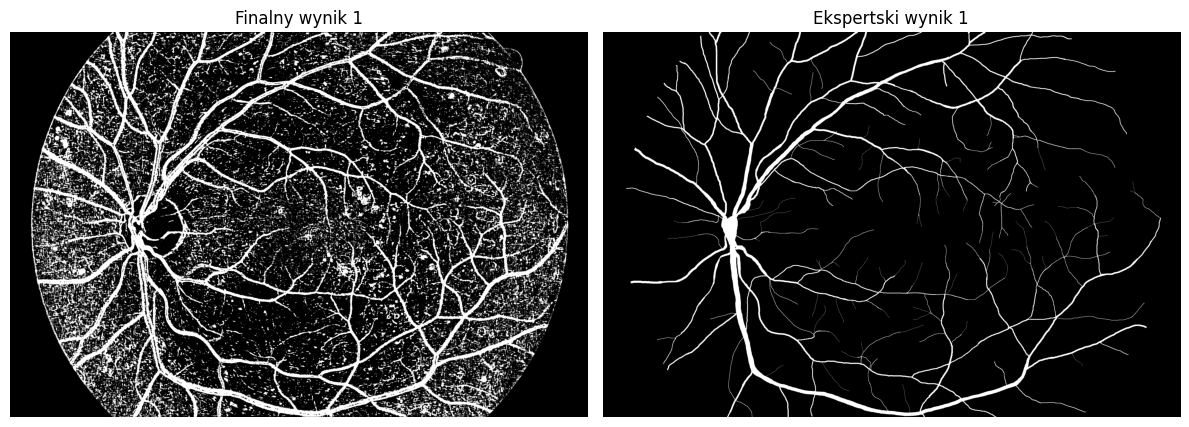

Displaying result for image 2/5


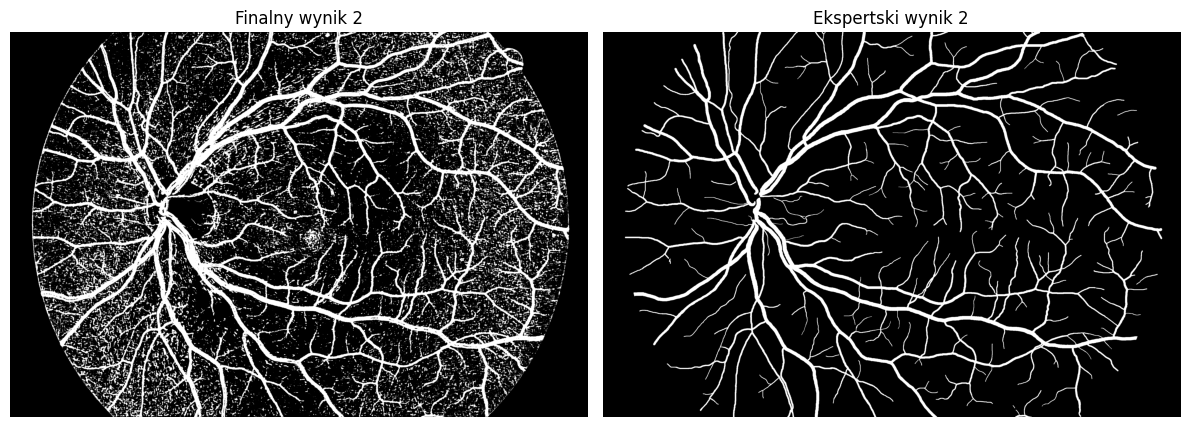

Displaying result for image 3/5


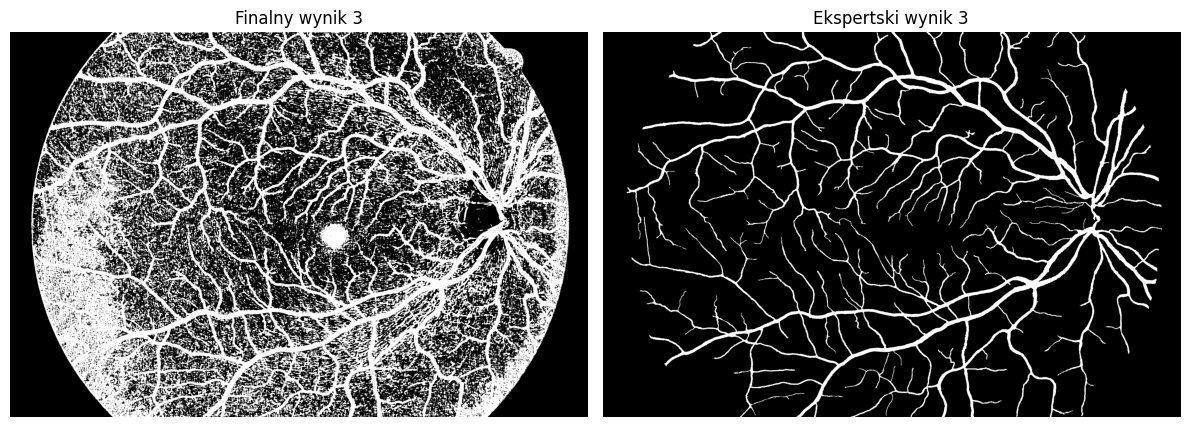

Displaying result for image 4/5


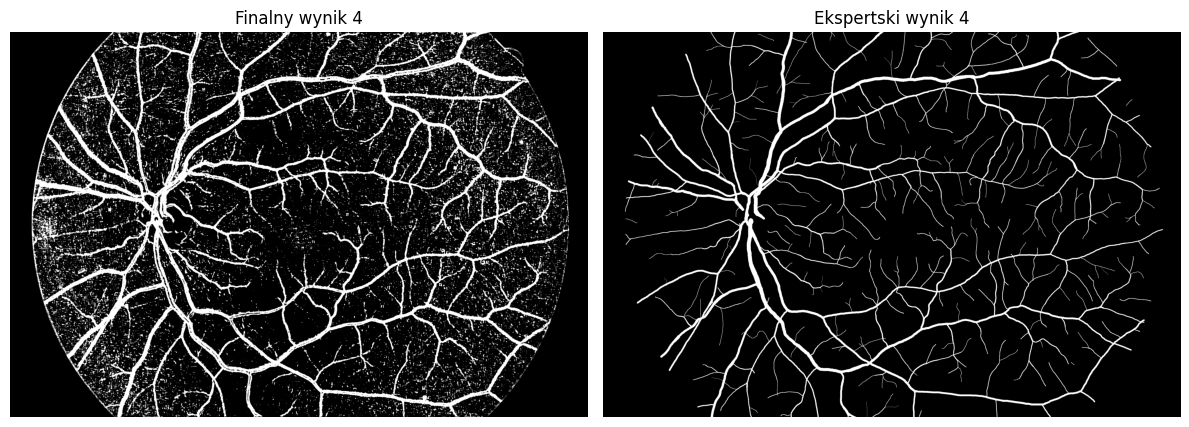

Displaying result for image 5/5


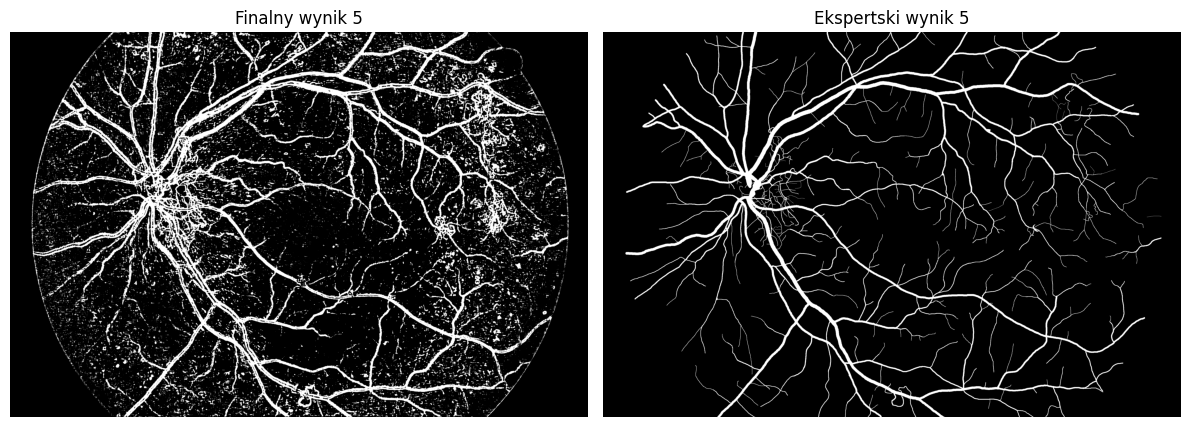

In [6]:
manual_paths = ['manual1/01_dr.tif', 'manual1/02_h.tif', 'manual1/11_h.tif', 'manual1/09_g.tif', 'manual1/12_dr.tif']
gray_manual_images = []

# Test model
test_images = ['images/01_dr.jpg', 'images/02_h.jpg', 'images/11_h.jpg', 'images/09_g.jpg', 'images/12_dr.jpg']

# Predict for each test image
print("Predicting masks for test images...")
predictions = []
for idx, test_image in enumerate(test_images):
    print(f"Processing test image {idx + 1}/{len(test_images)}: {test_image}")
    test_img = io.imread(test_image)
    X_test = image_to_X(test_img, patch_size)
    y_pred = model.predict(X_test)
    y_pred = y_pred.reshape(test_img.shape[0], test_img.shape[1])
    predictions.append(y_pred)

# Save predicted masks as PNG files
print("Saving predicted masks as PNG files...")
for idx, y_pred in enumerate(predictions, start=1):
    file_path = f"y_pred_{idx}.png"
    cv2.imwrite(file_path, (y_pred * 255).astype(np.uint8))
    print(f"Saved predicted mask: {file_path}")

# Display predictions and manual images
print("Displaying predictions and manual images...")
for ind in range(len(manual_paths)):
    print(f"Displaying result for image {ind + 1}/{len(manual_paths)}")
    manual_image_path = manual_paths[ind]
    manual_image = cv2.imread(manual_image_path)
    
    # Resize manual image to match the dimensions of the prediction
    pred_shape = predictions[ind].shape
    manual_image = cv2.resize(manual_image, (pred_shape[1], pred_shape[0]))
    gray_manual_image = cv2.cvtColor(manual_image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(predictions[ind], cmap='gray')
    plt.title(f'Finalny wynik {ind + 1}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(gray_manual_image, cmap='gray')
    plt.title(f'Ekspertski wynik {ind + 1}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Compiling test_images and test_masks...
Compiling X_tests and y_tests...
Compiling y_preds and y_preds_reshaped...
Calculating confusion matrices using additional masks...
Processing confusion matrix for test image 1/5: 01_dr.jpg
True Positive for test image 1: 1847457
False Positive for test image 1: 7
False Negative for test image 1: 5065534
True Negative for test image 1: 1272346

Trafność for test image 1: 0.3811450074670044
Czułość for test image 1: 0.2672442362502714
Swoistość for test image 1: 0.9999944983821314
Średnia arytmetyczna czułości i swoistości for test image 1: 0.6336193673162014



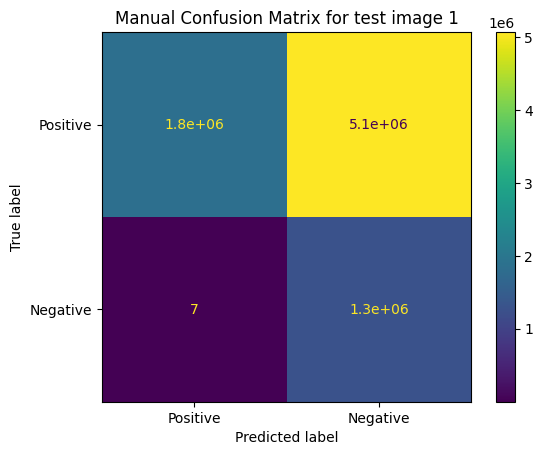

Processing confusion matrix for test image 2/5: 02_h.jpg
True Positive for test image 2: 1867037
False Positive for test image 2: 10
False Negative for test image 2: 5047332
True Negative for test image 2: 1270965

Trafność for test image 2: 0.3833683715675236
Czułość for test image 2: 0.2700227598498142
Swoistość for test image 2: 0.9999921320246268
Średnia arytmetyczna czułości i swoistości for test image 2: 0.6350074459372205



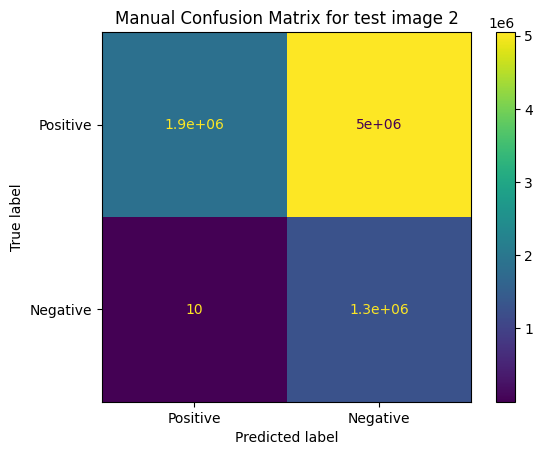

Processing confusion matrix for test image 3/5: 11_h.jpg
True Positive for test image 3: 3472340
False Positive for test image 3: 207
False Negative for test image 3: 3441701
True Negative for test image 3: 1271096

Trafność for test image 3: 0.5795035614874585
Czułość for test image 3: 0.5022157085848927
Swoistość for test image 3: 0.9998371749299734
Średnia arytmetyczna czułości i swoistości for test image 3: 0.751026441757433



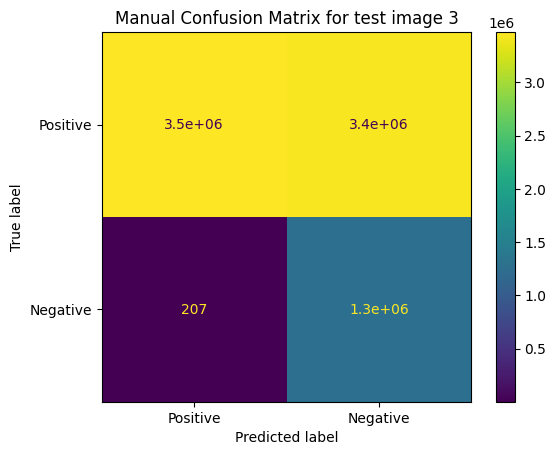

Processing confusion matrix for test image 4/5: 09_g.jpg
True Positive for test image 4: 1377773
False Positive for test image 4: 8
False Negative for test image 4: 5537872
True Negative for test image 4: 1269691

Trafność for test image 4: 0.3234395524488647
Czułość for test image 4: 0.19922552415573674
Swoistość for test image 4: 0.9999936992940847
Średnia arytmetyczna czułości i swoistości for test image 4: 0.5996096117249107



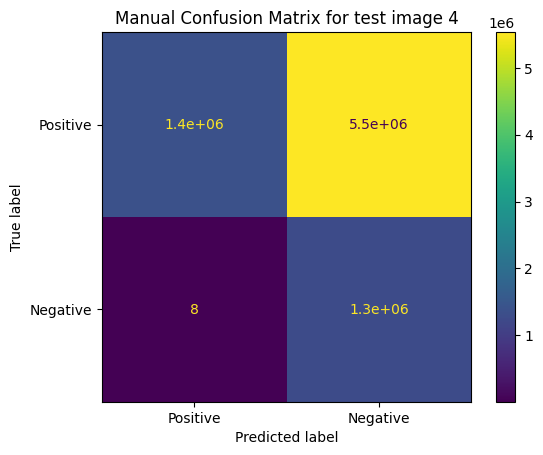

Processing confusion matrix for test image 5/5: 12_dr.jpg
True Positive for test image 5: 1319336
False Positive for test image 5: 3
False Negative for test image 5: 5594788
True Negative for test image 5: 1271217

Trafność for test image 5: 0.3164867597501095
Czułość for test image 5: 0.19081752077341974
Swoistość for test image 5: 0.9999976400623024
Średnia arytmetyczna czułości i swoistości for test image 5: 0.5954075804178611



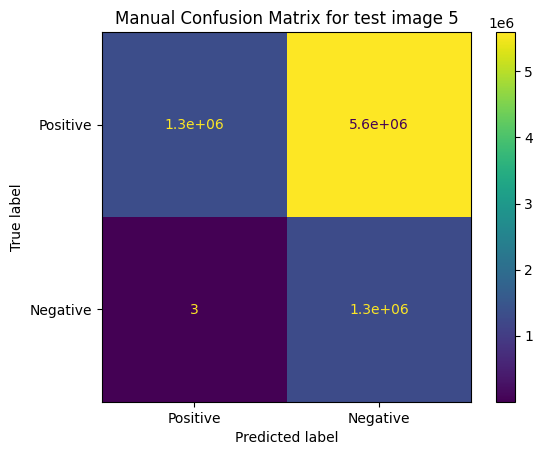

Processing complete.


In [10]:
test_files = ['01_dr.jpg', '02_h.jpg', '11_h.jpg', '09_g.jpg', '12_dr.jpg']

print("Compiling test_images and test_masks...")
test_images = [io.imread(os.path.join(image_folder, f)) for f in test_files]
test_masks = [io.imread(os.path.join(mask_folder, f.replace('.jpg', '.tif')), as_gray=True).astype(np.uint8) for f in test_files]

print("Compiling X_tests and y_tests...")
X_tests = [image_to_X(img, patch_size) for img in test_images]
y_tests = [mask_to_y(mask) for mask in test_masks]

print("Compiling y_preds and y_preds_reshaped...")
y_preds = [model.predict(X_test) for X_test in X_tests]
y_preds_reshaped = [y_pred.reshape(img.shape[0], img.shape[1]) for y_pred, img in zip(y_preds, test_images)]

# Calculate and display confusion matrices using additional masks
print("Calculating confusion matrices using additional masks...")
for i, (image_file, y_test, y_pred) in enumerate(zip(test_files, y_tests, y_preds)):
    print(f"Processing confusion matrix for test image {i + 1}/{len(test_files)}: {image_file}")
    mask_path = os.path.join(additional_mask_folder, image_file.replace('.jpg', '_mask.tif'))
    additional_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Resize mask to match the size of the predicted images
    resized_shape = y_pred.reshape(y_preds_reshaped[0].shape).shape  # use shape of predicted images
    additional_mask_resized = cv2.resize(additional_mask, (resized_shape[1], resized_shape[0]))

    threshold = 127
    correct_mask = additional_mask_resized > threshold
    pred_mask = y_pred.reshape(resized_shape[0], resized_shape[1]) > 0

    # Calculate confusion matrix manually
    true_positive = np.sum((correct_mask == True) & (pred_mask == True))
    false_positive = np.sum((correct_mask == False) & (pred_mask == True))
    false_negative = np.sum((correct_mask == True) & (pred_mask == False))
    true_negative = np.sum((correct_mask == False) & (pred_mask == False))

    print(f"True Positive for test image {i+1}: {true_positive}")
    print(f"False Positive for test image {i+1}: {false_positive}")
    print(f"False Negative for test image {i+1}: {false_negative}")
    print(f"True Negative for test image {i+1}: {true_negative}\n")
    
    # Calculate and print the performance metrics
    accuracy = (true_positive + true_negative) / (true_positive + false_positive + false_negative + true_negative)
    sensitivity = true_positive / (true_positive + false_negative)
    specificity = true_negative / (true_negative + false_positive)
    avg_sens_spec = (sensitivity + specificity) / 2
    
    print(f"Trafność for test image {i+1}: {accuracy}")
    print(f"Czułość for test image {i+1}: {sensitivity}")
    print(f"Swoistość for test image {i+1}: {specificity}")
    print(f"Średnia arytmetyczna czułości i swoistości for test image {i+1}: {avg_sens_spec}\n")
    
    # Display confusion matrix as a plot
    manual_cm = np.array([[true_positive, false_negative],
                          [false_positive, true_negative]])

    disp_manual = ConfusionMatrixDisplay(confusion_matrix=manual_cm, display_labels=['Positive', 'Negative'])
    disp_manual.plot(cmap='viridis')
    plt.title(f'Manual Confusion Matrix for test image {i+1}')
    plt.show()

print("Processing complete.")

## Uczenie maszynowe krok po kroku
1. Wczytaj obrazy i maski z folderów `images` i `manual1`.
2. Dla każdej pary obraz-maskę:
    A. Przekształć obraz na macierz `X` zawierającą patche o rozmiarze patch_size.
    B. Przekształć maskę na wektor `y`.
3. Połącz wszystkie macierze `X` i wektory `y` w jedną macierz `X_train` i wektor `y_train`.
4. Wybierz losowo 5% przykładów z `X_train` i `y_train`.
5. Zastosuj undersampling do wybranych przykładów.
6. Wytrenuj model `RandomForestClassifier` z 200 drzewami.
7. Zapisz wytrenowany model do pliku `model-green.pkl`.